In [28]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import glob
import pickle
import platform
import copy

import proplot as pplt
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from vendi_score import vendi
from matplotlib.ticker import MaxNLocator
from graph_utils import *
from data_utils import *
from model_utils import *
from analysis_utils import *
from saliency_utils import *
from generation_utils import *

DATA_DIR = '/scratch/gpfs/sj0161/topo_data/'
WEIGHT_DIR = '/scratch/gpfs/sj0161/topo_result/'
ANALYSIS_DIR = '/scratch/gpfs/sj0161/topo_analysis/'
PLOT_DIR = '/scratch/gpfs/sj0161/topo_figure/'



pplt.rc['figure.facecolor'] = 'white'

COLORS = []
colors = pplt.Cycle('538')
for color in colors:
    COLORS.append(color['color'])
colors = pplt.Cycle('default')
for color in colors:
    COLORS.append(color['color'])

LATENT_DIM = 8
DT = 0.001
NAMES = ['linear','cyclic', 'branch', 'comb', 'star', 'dendrimer']

# Schematic Drawing of Polymer Topologies

In [8]:
with open(os.path.join(DATA_DIR,'rg2.pickle'), 'rb') as handle:
    adj = pickle.load(handle)
    rg_label = pickle.load(handle)
    graph_desc = pickle.load(handle)
    top_label = pickle.load(handle)
    poly_meta = pickle.load(handle)
    graph = pickle.load(handle)

top_label[top_label == 'astar'] = 'star'


g1 = []
l1 = []

for u in NAMES:
    idx = np.where(top_label == u)[0]
    n = int(len(idx) * 0.05)

    if n == 0:
        n = 1
    
    if u == 'star' or u == 'dendrimer':
        n -= 1
    
    idx = np.random.RandomState(26).choice(idx, n)

    g1.append(graph[idx])
    l1.append(top_label[idx])

g1 = np.concatenate(g1)
l1 = np.concatenate(l1)

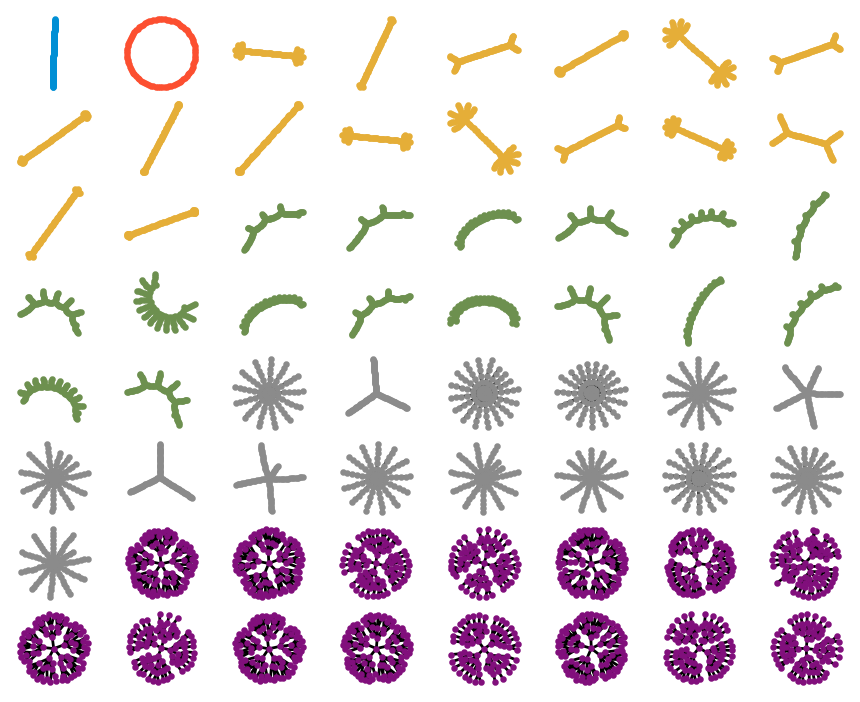

In [14]:
fig, ax = pplt.subplots(ncols=8, nrows=8, refheight=3.3/8, refwidth=3.3/8, hspace=0.1)

for i in range(len(ax)):
    color = COLORS[np.where(np.array(NAMES) == l1[i])[0][0]]
    nx.draw(g1[i], node_size=3, ax=ax[i], pos=nx.kamada_kawai_layout(g1[i]), node_color=color)

fig.savefig(os.path.join(PLOT_DIR, 'example_graph.png'), dpi=300, bbox_inches='tight')

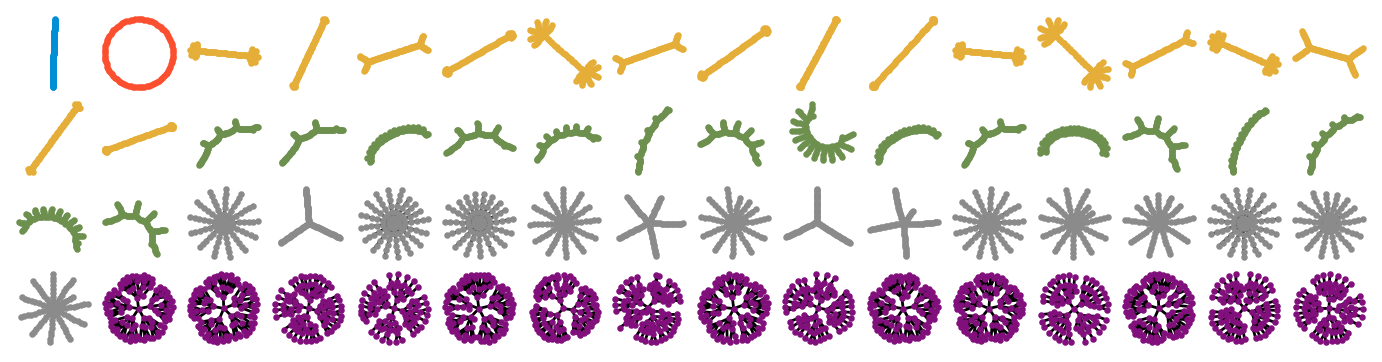

In [15]:
fig, ax = pplt.subplots(ncols=16, nrows=4, refheight=3.3/8, refwidth=3.3/8, hspace=0.1, wspace=0.1)

for i in range(len(ax)):
    color = COLORS[np.where(np.array(NAMES) == l1[i])[0][0]]
    nx.draw(g1[i], node_size=3, ax=ax[i], pos=nx.kamada_kawai_layout(g1[i]), node_color=color)

fig.savefig(os.path.join(PLOT_DIR, 'example_graph_v2.png'), dpi=300, bbox_inches='tight')

# Statistical Distribution of Rg² for Each Polymer Topology Type (Histogram)

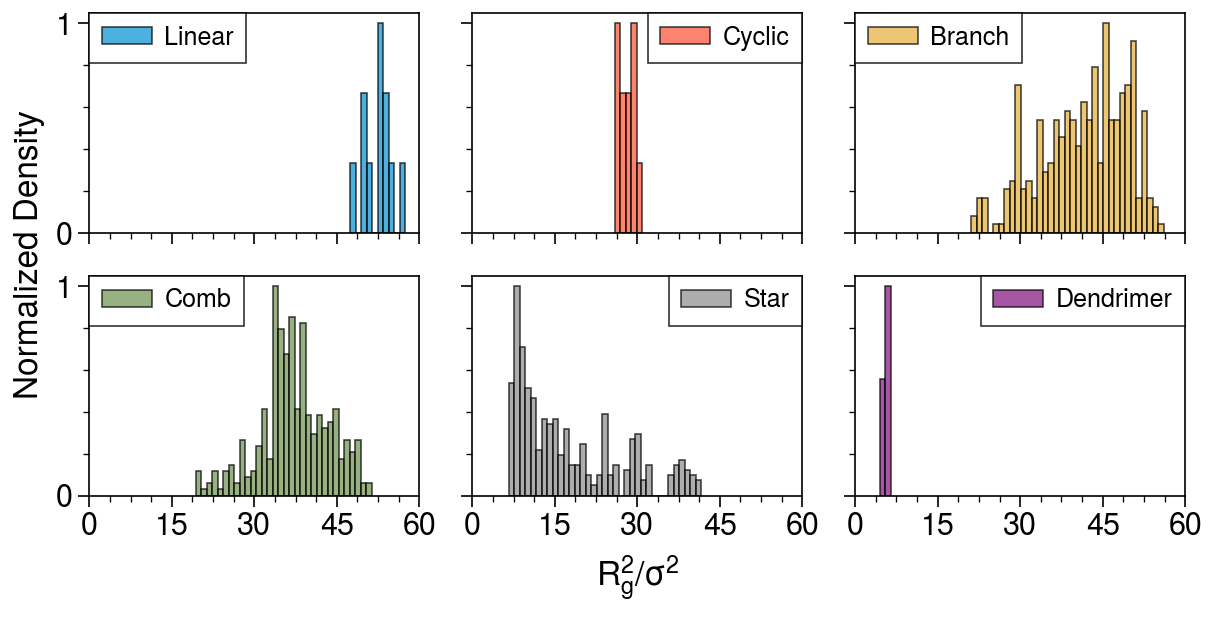

In [18]:
fig, ax = pplt.subplots(ncols=3, nrows=2, refheight=3.3/3, refwidth=3.3/2)

for i in range(len(NAMES)):
    idx = np.where(top_label == NAMES[i])[0]
    rg_ = rg_label[idx, 0]
    bin_width = 1
    min_val = np.min(rg_)
    max_val = np.max(rg_)
    bins = np.arange(min_val, max_val + bin_width, bin_width)
    hist, bins = np.histogram(rg_, bins=bins, density=False)
    hist = hist / hist.max()

    ax[i].bar(bins[:-1], hist, width=1, edgecolor='k', alpha=0.7, color=COLORS[i], label=NAMES[i].capitalize())


    ax[i].xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax[i].yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

    ax[i].legend()

    ax[i].format(xlabel=r"$R_{g}^2/\sigma^2$", ylabel=r"Normalized Density",
                 xlim=[0, 60], xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid='off')

fig.savefig(os.path.join(PLOT_DIR, 'rg_by_topology.png'), dpi=300, bbox_inches='tight')

# Statistical Distribution of Rg² for Each Polymer Topology Type (Violin Plot)

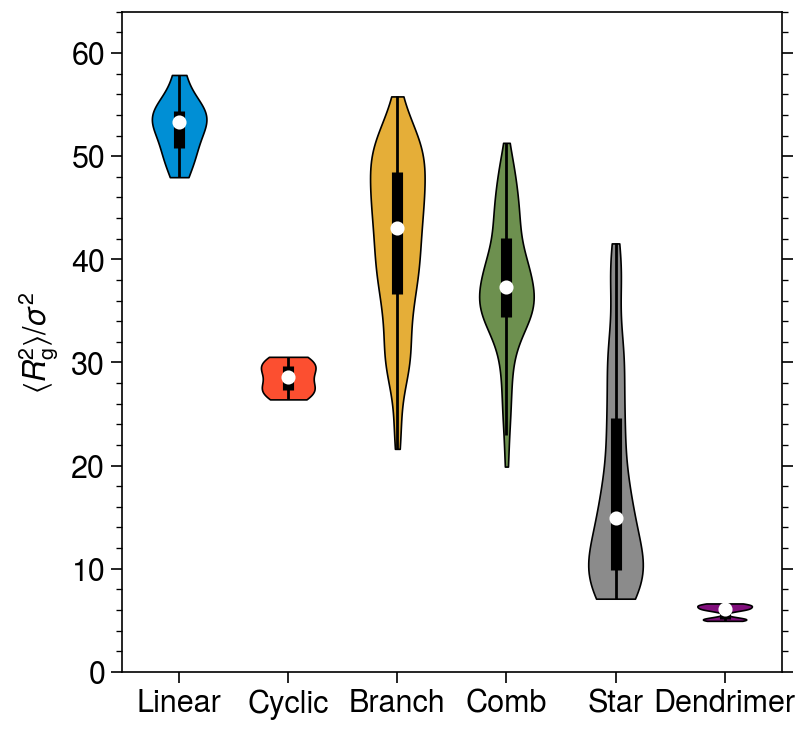

In [19]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


fig, ax = pplt.subplots(ncols=1, nrows=1, refheight=3.3, refwidth=3.3)

for i in range(len(NAMES)):
    idx = np.where(top_label == NAMES[i])[0]
    rg_ = rg_label[idx, 0]

    violin = ax.violinplot(i, rg_)

    for pc in violin:
        pc.set_facecolor(COLORS[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    sorted_rg_ = np.sort(rg_)

    quartile1, medians, quartile3 = np.percentile(sorted_rg_, [25, 50, 75])
    whisker_min, whisker_max = adjacent_values(sorted_rg_, quartile1, quartile3)

    ax.scatter(i, medians, marker='o', color='white', s=20, zorder=3)
    ax.vlines(i, quartile1, quartile3, color='k', linestyle='-', lw=4)
    ax.vlines(i, whisker_min, whisker_max, color='k', linestyle='-', lw=1)

ax.format(ylabel=r"$\langle {\mathit{R}}_{\mathrm{g}}^2 \rangle / \mathit{\sigma}^2$", xticks=[0,1,2,3,4,5], xticklabels=[NAMES_.capitalize() for NAMES_ in NAMES],
                xlabelsize=11, ylabelsize=11, xticklabelsize=11, yticklabelsize=11, grid='off', ylim=[0, 64])
ax.set_xticks([], minor=True)
ax.yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")

fig.savefig(os.path.join(PLOT_DIR, 'rg_by_topology_violin.png'), dpi=300, bbox_inches='tight')

# Graphical Abstract Figures

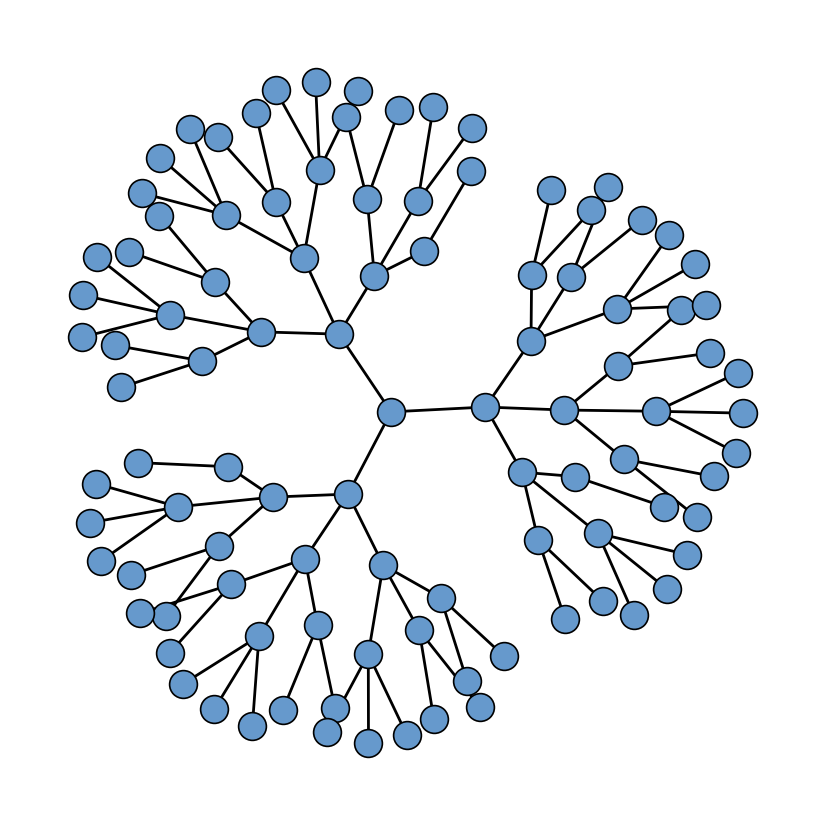

In [21]:
graph_exp = graph[np.where(np.array(poly_meta) == '3_4_100_2')[0][0]]

fig, ax = pplt.subplots(refwidth=4, refheight=4)

nx.draw(graph_exp, pos=nx.kamada_kawai_layout(graph_exp), ax=ax,
        node_size=100, node_color='#6699cc', edge_color='k')

ax.collections[0].set_edgecolor('k')

fig.savefig(os.path.join(PLOT_DIR, 'example_graph_dendrimer.svg'), bbox_inches='tight', transparent=True)

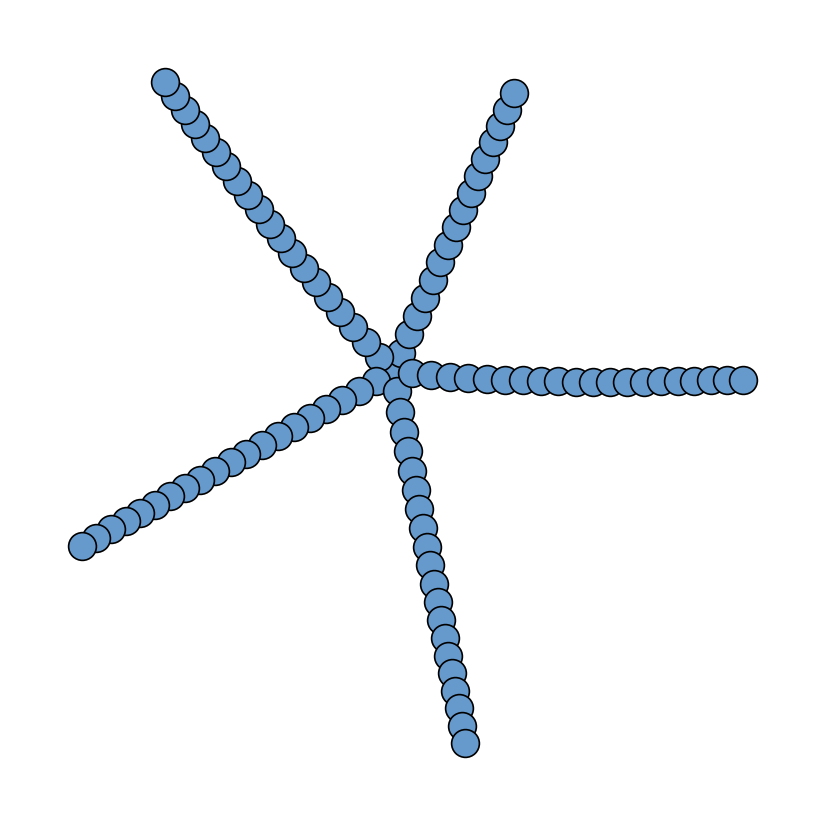

In [23]:
graph_exp = graph[np.where(np.array(top_label) == 'star')[0][77]]

fig, ax = pplt.subplots(refwidth=4, refheight=4)

nx.draw(graph_exp, pos=nx.kamada_kawai_layout(graph_exp), ax=ax,
        node_size=100, node_color='#6699cc', edge_color='k')

ax.collections[0].set_edgecolor('k')

fig.savefig(os.path.join(PLOT_DIR, 'example_graph_star.svg'), bbox_inches='tight', transparent=True)

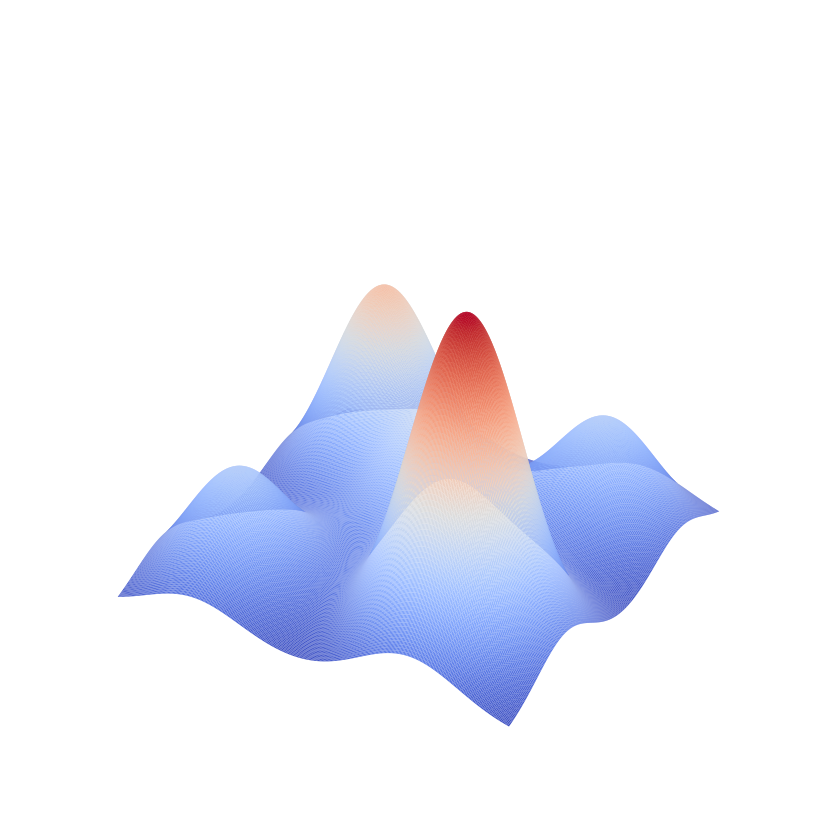

In [24]:
fig, ax = pplt.subplots(refheight=4, refwidth=4, proj={1: '3d'})

x = np.linspace(-2, 2, 300)
y = np.linspace(-2, 2, 300)
x, y = np.meshgrid(x, y)
z = (0.3 * np.exp(-((x + 0) ** 2 + (y - 0.2) ** 2) / (2 * 0.5 ** 2))+
     0.3 * np.exp(-((x -1.2) ** 2 + (y - 1.2) ** 2) / (2 * 0.5 ** 2))+
     0.3 * np.exp(-((x + 1.2) ** 2 + (y + 1.2) ** 2) / (2 * 0.5 ** 2))+
     0.8 * np.exp(-((x - 1) ** 2 + (y + 1) ** 2) / (2 * 0.5 ** 2)) +
     0.5 * np.exp(-((x + 1) ** 2 + (y - 1) ** 2) / (2 * 0.5 ** 2)))

surf = ax.plot_surface(x, y, z, cmap='coolwarm', rstride=1, cstride=1, antialiased=True)

ax.axis('off')

fig.savefig(os.path.join(PLOT_DIR, 'example_latent_surface.png'), transparent=True, bbox_inches='tight', dpi=300)


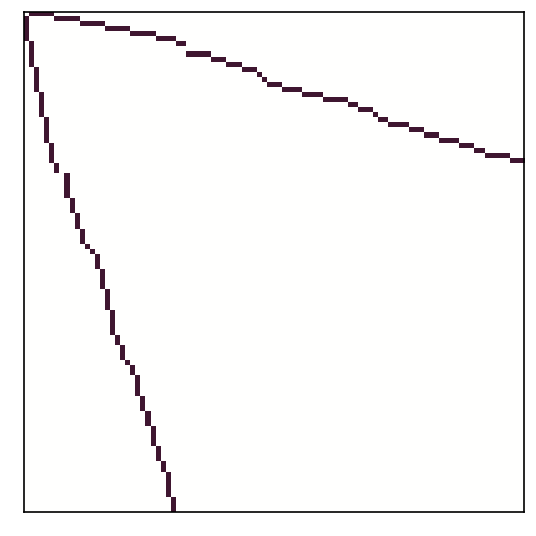

In [25]:
fig, ax = pplt.subplots()
adj_example_dendrimer = nx.to_numpy_array(graph[-43])
ax.imshow(adj_example_dendrimer)
ax.set_xticks([])
ax.set_yticks([])

fig.savefig(os.path.join(PLOT_DIR, 'example_dendrimer_adj.png'), transparent=True, bbox_inches='tight', dpi=300)

# Topological Descriptor Illustration

In [26]:
desc2 = []

cls = ['linear', 'cyclic', 'comb', 'branch', 'star', 'dendrimer']

for c in cls:
    idx = np.where(top_label == c)[0]
    desc_temp = graph_desc[idx]
    ord = np.argsort(desc_temp[:, 0])
    desc_temp = desc_temp[ord]

    desc2.append(desc_temp)

desc2 = np.concatenate(desc2)

ss = StandardScaler()
desc2 = np.nan_to_num(desc2, nan=0)
desc2 = ss.fit_transform(desc2)

desc2 = desc2[:, [0, 1, 5, 6, 7, 3, 4, 2, 8, 9, 10]]

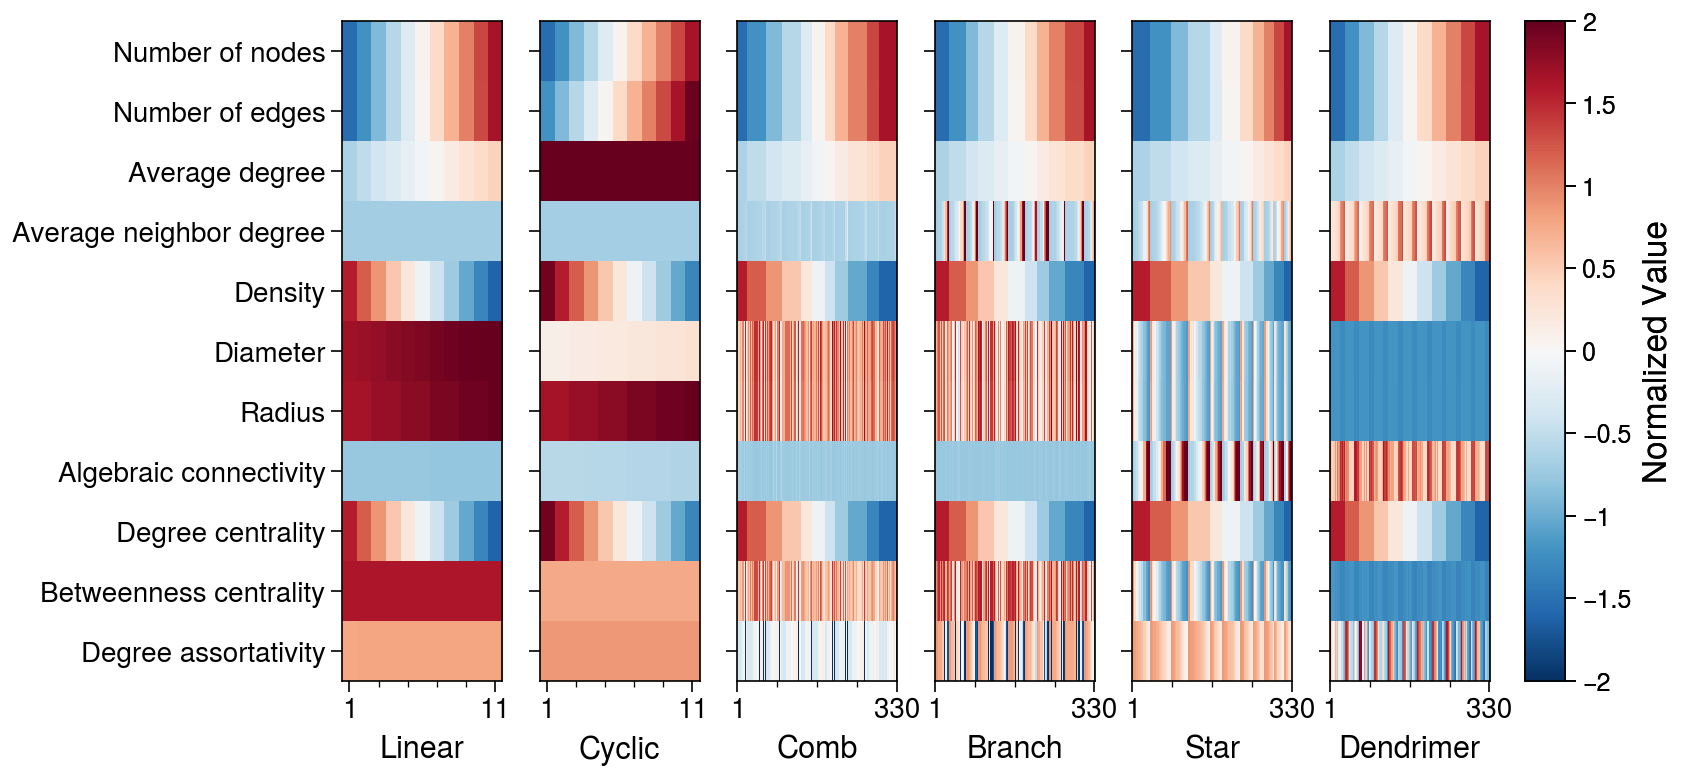

In [29]:
fig, ax = pplt.subplots(refwidth=.8, refheight=3.3, ncols=6, sharex=False, wspace=1.5)

def new_idx(x):
    unique_values, inverse, counts = np.unique(x[:, 0], return_inverse=True, return_counts=True)
    rank_idx = np.argsort(inverse)
    start_idx = 0
    for count in counts:
        end_idx = start_idx + count
        subset_idx = rank_idx[start_idx:end_idx]
        sorted_idx_in_subset = np.argsort(x[subset_idx, 3])
        rank_idx[start_idx:end_idx] = subset_idx[sorted_idx_in_subset]
        start_idx = end_idx
    return x[rank_idx]


im = ax[0].imshow(new_idx(desc2[:11]).T, aspect='auto', interpolation='none', vmin=-2, vmax=2)
ax[1].imshow(new_idx(desc2[11:22]).T, aspect='auto', interpolation='none', vmin=-2, vmax=2)
ax[2].imshow(new_idx(desc2[22:352]).T, aspect='auto', interpolation='none', vmin=-2, vmax=2)
ax[3].imshow(new_idx(desc2[352:682]).T, aspect='auto', interpolation='none', vmin=-2, vmax=2)
ax[4].imshow(new_idx(desc2[682:1012]).T, aspect='auto', interpolation='none', vmin=-2, vmax=2)
ax[5].imshow(new_idx(desc2[1012:]).T, aspect='auto', interpolation='none', vmin=-2, vmax=2)


ax[0].set_yticks(np.arange(11))
ll = ['Number of nodes', 'Number of edges', 'Algebraic connectivity', 'Diameter', 'Radius', 
                    'Average degree', 'Average neighbor degree', 'Density', 
                    'Degree centrality', 'Betweenness centrality', 'Degree assortativity']
ll = [ll[i] for i in [0, 1, 5, 6, 7, 3, 4, 2, 8, 9, 10]]

ax[0].set_yticklabels(ll, rotation=0, multialignment='right')

labels_ = ['Linear', 'Cyclic', 'Comb', 'Branch', 'Star', 'Dendrimer']
for i in range(6):
    ax[i].set_xlabel(labels_[i])
    ax[i].set_xticks(np.arange(11))

for i in range(2):
    ax[i].set_xticks([0, 10])
    ax[i].set_xticklabels([1, 11])
    ax[i].yaxis.set_minor_locator(plt.NullLocator())

for i in range(2,6):
    ax[i].set_xticks([0, 329])
    ax[i].set_xticklabels([1, 330])

plt.colorbar(im, ax=ax[5], title='Normalized Value', labelsize=12)

for i, ax_ in enumerate(ax):
    ax_.format(xlabelsize=11, ylabelsize=10, xticklabelsize=10, yticklabelsize=10, grid='off')

fig.savefig(os.path.join(PLOT_DIR, 'topological_descriptors.png'), dpi=300, bbox_inches='tight')

# Topological Descriptor Relationship with Rg²

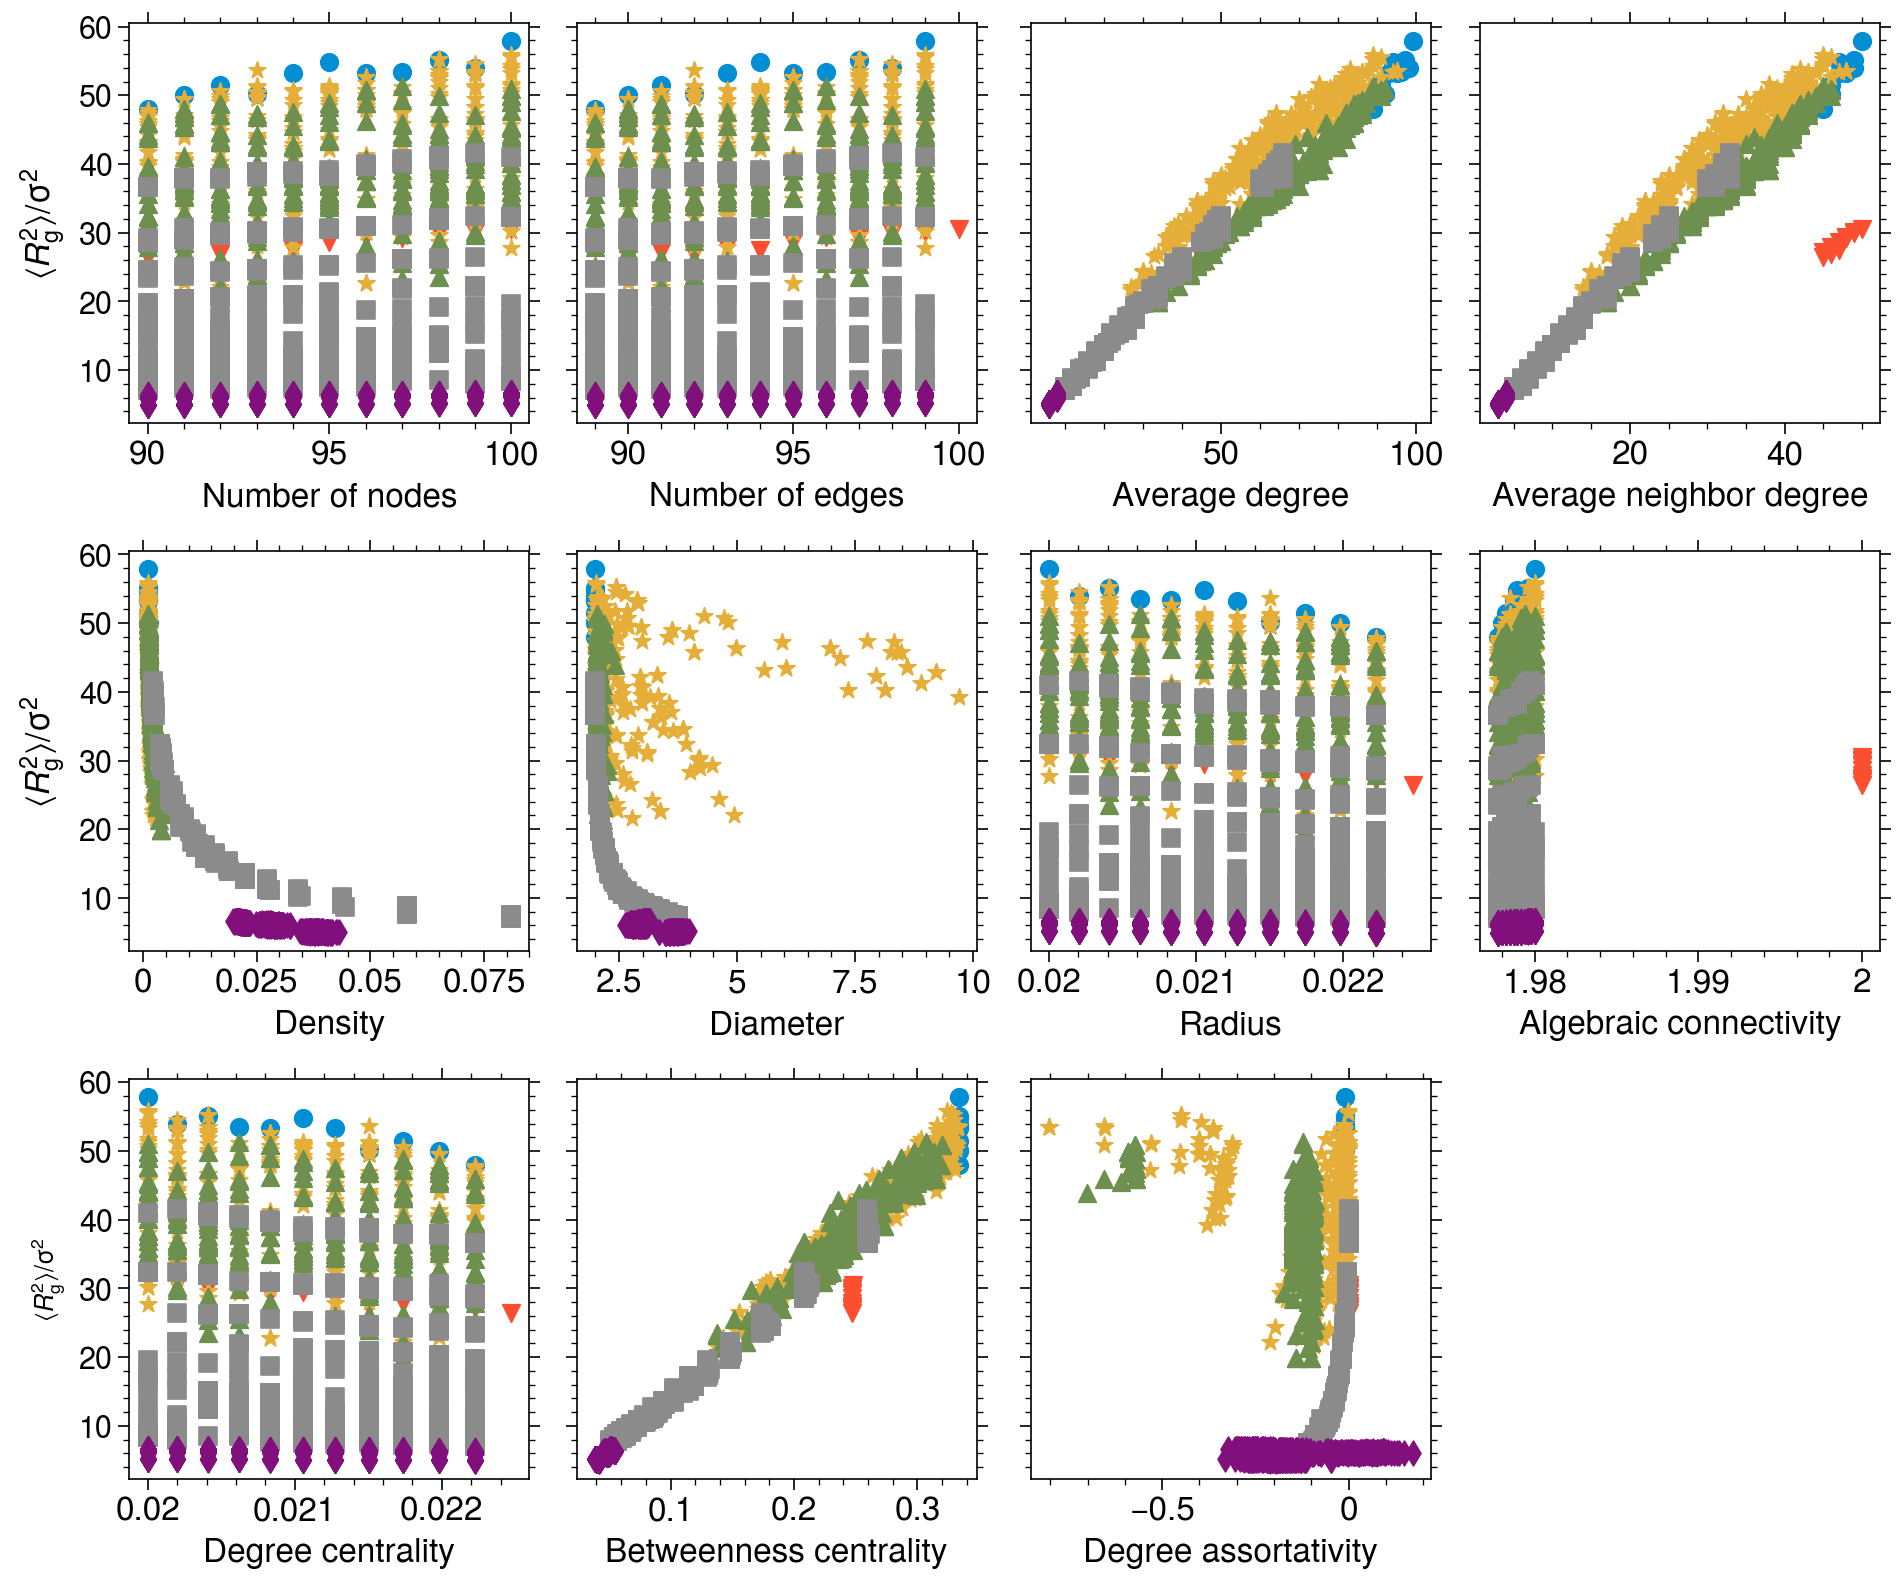

In [32]:
ll = ['Number of nodes', 'Number of edges', 'Algebraic connectivity', 'Diameter', 'Radius', 
                    'Average degree', 'Average neighbor degree', 'Density', 
                    'Degree centrality', 'Betweenness centrality', 'Degree assortativity']

NAMES = ['Linear', 'Cyclic', 'Branch', 'Comb', 'Star', 'Dendrimer']
MARKERS = ["o", "v", "*", "^", "s", "d"]

ll = [ll[i] for i in [0, 1, 5, 6, 7, 3, 4, 2, 8, 9, 10]]

graph_desc = np.nan_to_num(graph_desc, nan=0)

graph_desc = graph_desc[:, [0, 1, 5, 6, 7, 3, 4, 2, 8, 9, 10]]

data = np.concatenate((rg_label[:, 0][..., None], graph_desc), axis=1)

fig, ax = pplt.subplots(nrows=3, ncols=4, sharex=False, span=False, refwidth=2, refheight=2)

for i in range(11):
    for k, name in enumerate(NAMES):
        idx = np.where(top_label == name.lower())[0]
        ax[i].scatter(data[idx, i+1], data[idx, 0], color=COLORS[k], s=40, marker=MARKERS[k])

    ax[i].format(ylabel=r"$\langle \mathit{R}_{g}^2 \rangle/\sigma^2$", xlabel=ll[i],
                    xlabelsize=12, ylabelsize=12, xticklabelsize=12, yticklabelsize=11, grid='off')
    
    ax[i].yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")
    ax[i].xaxis.set_tick_params(labeltop=False, labelbottom=True, top=True, bottom=True, which="both")

ax[-1].axis("off")

fig.savefig(os.path.join(PLOT_DIR, 'rg_desc.png'), dpi=300, bbox_inches='tight')